<a href="https://colab.research.google.com/github/lsiecker/Deep-Learning/blob/Task-1/assignment_2/Assignment_2_2AMM10_22_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Details

## Group Name: group21

### Student 1: N.P.G.T. van Beuningen	1353624

### Student 2: D.P.M. van der Hoorn	1873334

### Student 3: L.R. Siecker	1344838

# Loading Data and Preliminaries

In [54]:
from google.colab import drive
import io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import requests
import pickle
import sklearn.metrics as sm
import time
from tqdm.notebook import tqdm, trange

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.cuda.memory import list_gpu_processes
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

In [55]:
base_url = "https://github.com/lsiecker/Deep-Learning/raw/main/assignment_2/data/"

In [56]:
def load_data(url, task):
    """
    Loads a numpy array from surfdrive.

    Input:
    url: Download link of dataset

    Outputs:
    dataset: numpy array with input features or labels
    """

    response = requests.get(url)
    response.raise_for_status()

    array = load_array(io.BytesIO(response.content), task)

    return array

In [57]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [58]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_data(f"{base_url}task%201/train/trajectory_0.npz?raw=true", task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [59]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time.
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_data(f'{base_url}task%202_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_data(f'{base_url}task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


# Helper Functions Setup

In [60]:
drive.mount('/content/drive')
destination_file = '/content/drive/MyDrive/'

def save_dataset(dataset, filename):
  "Saves dataset into file on Google Drive"
  filename = destination_file + filename
  with open(filename, 'wb') as file:
     pickle.dump(dataset, file)
  print(f"Dataset saved to {filename}.")

def load_dataset(filename):
  "Loades dataset from file on Google Drive"
  filename = destination_file + filename
  with open(filename, 'rb') as file:
      dataset = pickle.load(file)
  return dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
class PlotTraining():
    def __init__(self):
      self.train_loss = []
      self.evaluation_loss = []
      self.test_loss = []

    def add_train(self, loss):
      self.train_loss.append(loss)

    def add_evaluation(self, loss):
      self.evaluation_loss.append(loss)

    def add_test(self, loss):
      self.test_loss.append(loss)

    def plot(self):
      fig, ax1 = plt.subplots()
      ax1.set_xlabel('epochs')
      ax1.tick_params(axis='x')
      ax2 = ax1.twinx()
      if self.train_loss is not [None] * len(self.train_loss) \
          or self.evaluation_loss is not [None] * len(self.evaluation_loss) \
          or self.test_loss is not [None] * len(self.test_loss):
        ax2.set_ylabel('loss')

      color = ["tab:blue", "tab:orange", "tab:purple", "tab:red", "tab:green", "tab:pink"]

      if self.train_loss:
        ax2.plot(list(range(len(self.train_loss))), self.train_loss, label = "Training Loss", color=color[1])
      if self.evaluation_loss:
        ax2.plot(list(range(len(self.evaluation_loss))), self.evaluation_loss, label = "Validation Loss", color=color[3])
      if self.test_loss:
        ax2.plot(list(range(len(self.test_loss))), self.test_loss, label = "Test Loss", color=color[5])

      fig.legend()
      fig.tight_layout()
      plt.locator_params(axis='x', integer=True, tight=True)
      plt.show()

In [62]:
def sequence_rotation(source_sequence):
    x = source_sequence[:, 1]
    y = source_sequence[:, 2]
    v_x = source_sequence[:, 3]
    v_y = source_sequence[:, 4]

    # Create four rotated copies of the batch of sequences
    rotated_sequences = [
        torch.stack([source_sequence[:, 0], x, y, v_x, v_y], dim=1),  # 0 degrees rotation
        torch.stack([source_sequence[:, 0], y, -x, -v_y, v_x], dim=1),  # 90 degrees rotation
        torch.stack([source_sequence[:, 0], -x, -y, -v_x, -v_y], dim=1),  # 180 degrees rotation
        torch.stack([source_sequence[:, 0], -y, x, v_y, -v_x], dim=1),  # 270 degrees rotation
    ]

    rotated_sequences_tensor = torch.stack(rotated_sequences, dim=1)  # Shape: [batch_size, 4, sequence_length, 5]

    return rotated_sequences_tensor.view(rotated_sequences_tensor.shape[0] * rotated_sequences_tensor.shape[1], 5)

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    # arrays are stored as tuples; get respective lists
    source_points = [x[0] for x in batch]
    target_points = [x[1] for x in batch]

    source_sequences = [sequence_rotation(sequence) for sequence in source_points]

    # pad sequences in batch
    source_padded = pad_sequence(sequences = source_sequences,
                             batch_first = True)
    target_padded = pad_sequence(sequences = target_points,
                             batch_first = True)

    return source_padded.to(device), target_padded.to(device)

In [63]:
def train(dataloader, log_interval, task23):

  model.train()

  start_time = time.time()
  for idx, (trajectory_points, target_points) in enumerate(tqdm(dataloader)):
        trajectory_points = trajectory_points.to(device)
        target_points = target_points.to(device)

        model.optimizer.zero_grad()
        y_pred = model(trajectory_points)

        if task23:
          reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4)
          loss = model.criterion(reshaped_y_pred, target_points)
        else:
          loss = model.criterion(y_pred, target_points)

        loss.backward()
        model.optimizer.step()

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| loss {:8.3f}'.format(epoch, idx, len(dataloader),
                                              loss))
            start_time = time.time()

  return loss

def evaluate(dataloader, task23):
    model.eval()

    with torch.no_grad():
        for idx, (trajectory_points, target_points) in enumerate(tqdm(dataloader)):

            trajectory_points = trajectory_points.to(device)
            target_points = target_points.to(device)

            y_pred = model(trajectory_points)
            if task23:
              reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4)
              loss = model.criterion(reshaped_y_pred, target_points)
            else:
              loss = model.criterion(y_pred, target_points)

    return loss

# Model Setup

In [64]:
class Encoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        self.dropout = nn.Dropout(dropout)

        self.double()


    def forward(self, src):
        """
        Forward pass of encoder model. It aims at
        transforming the input sentence to a dense vector
        """

        output, _ = self.rnn(src)

        return output

In [65]:
class Decoder(nn.Module):
    def __init__(self, output_size, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(hid_dim, hid_dim, n_layers, dropout = dropout)

        self.fc_out = nn.Linear(hid_dim, output_size)

        self.dropout = nn.Dropout(dropout)

        self.double()


    def forward(self, input):
        """
        Forward pass of the decoder model. It aims at transforming
        the dense representation of the encoder into a sequence that is
        used for position prediction
        """

        output, _ = self.rnn(input)

        prediction = self.fc_out(output)

        # Only select points that were in original dataset
        reduced_output = prediction[:, ::4, :]

        return reduced_output

In [66]:
class TrainPointPredictor(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        self.criterion = nn.MSELoss()

        self.double()


    def forward(self, source_points):
        """
        Forward pass of the seq2seq model. It encodes the source sentence into
        a dense representation and thereafter transduces into the target
        sentence.

        Inputs:
        src: padded index representation of source sentences with shape [src len, batch size]
        trg:  padded index representation of target sentences with shape [trg len, batch size]

        Outputs:
        output:
        """

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        input = self.encoder(source_points)
        output = self.decoder(input)

        return output

# Task **1**

## Data Handling and Preprocessing

In [67]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%201/train/trajectory_{i}.npz?raw=true", task='task 1'))
  save_dataset(train_data, "train_data")

In [68]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%201/test/trajectory_{i}.npz?raw=true", task='task 1'))
  save_dataset(test_data, "test_data")

In [69]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_batch)

## Model Training

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time:  1.71s | train loss   17.498 validation loss   16.497 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time:  1.36s | train loss   14.133 validation loss   11.893 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time:  0.83s | train loss    8.104 validation loss    7.704 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time:  0.67s | train loss    6.302 validation loss    6.777 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time:  0.68s | train loss    5.787 validation loss    6.118 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time:  0.67s | train loss    5.471 validation loss    5.703 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time:  0.66s | train loss    5.293 validation loss    5.498 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time:  0.66s | train loss    5.168 validation loss    5.385 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time:  0.67s | train loss    5.084 validation loss    5.307 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  10 | time:  0.67s | train loss    5.023 validation loss    5.239 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  11 | time:  0.65s | train loss    4.978 validation loss    5.177 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  12 | time:  0.66s | train loss    4.943 validation loss    5.119 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  13 | time:  0.66s | train loss    4.915 validation loss    5.065 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  14 | time:  0.66s | train loss    4.893 validation loss    5.017 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  15 | time:  0.67s | train loss    4.875 validation loss    4.974 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  16 | time:  0.68s | train loss    4.860 validation loss    4.933 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  17 | time:  0.69s | train loss    4.846 validation loss    4.894 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  18 | time:  0.67s | train loss    4.834 validation loss    4.859 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  19 | time:  0.83s | train loss    4.823 validation loss    4.825 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  20 | time:  0.85s | train loss    4.812 validation loss    4.793 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  21 | time:  0.88s | train loss    4.800 validation loss    4.763 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  22 | time:  0.88s | train loss    4.789 validation loss    4.735 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  23 | time:  0.80s | train loss    4.776 validation loss    4.710 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  24 | time:  0.74s | train loss    4.763 validation loss    4.687 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  25 | time:  0.67s | train loss    4.748 validation loss    4.666 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  26 | time:  0.67s | train loss    4.732 validation loss    4.648 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  27 | time:  0.69s | train loss    4.717 validation loss    4.633 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  28 | time:  0.69s | train loss    4.702 validation loss    4.620 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  29 | time:  0.69s | train loss    4.690 validation loss    4.609 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  30 | time:  0.69s | train loss    4.680 validation loss    4.601 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  31 | time:  0.71s | train loss    4.672 validation loss    4.594 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  32 | time:  0.69s | train loss    4.665 validation loss    4.589 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  33 | time:  0.67s | train loss    4.660 validation loss    4.586 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  34 | time:  0.68s | train loss    4.655 validation loss    4.584 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  35 | time:  0.68s | train loss    4.652 validation loss    4.583 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  36 | time:  0.68s | train loss    4.649 validation loss    4.583 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  37 | time:  0.69s | train loss    4.646 validation loss    4.584 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  38 | time:  0.69s | train loss    4.643 validation loss    4.585 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  39 | time:  0.85s | train loss    4.641 validation loss    4.588 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  40 | time:  0.86s | train loss    4.639 validation loss    4.590 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  41 | time:  0.90s | train loss    4.637 validation loss    4.593 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  42 | time:  0.81s | train loss    4.635 validation loss    4.596 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  43 | time:  0.83s | train loss    4.634 validation loss    4.599 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  44 | time:  0.81s | train loss    4.632 validation loss    4.602 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  45 | time:  0.73s | train loss    4.630 validation loss    4.606 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  46 | time:  0.68s | train loss    4.628 validation loss    4.609 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  47 | time:  0.69s | train loss    4.627 validation loss    4.613 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  48 | time:  0.69s | train loss    4.625 validation loss    4.617 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  49 | time:  0.68s | train loss    4.623 validation loss    4.621 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  50 | time:  0.70s | train loss    4.622 validation loss    4.625 
-----------------------------------------------------------


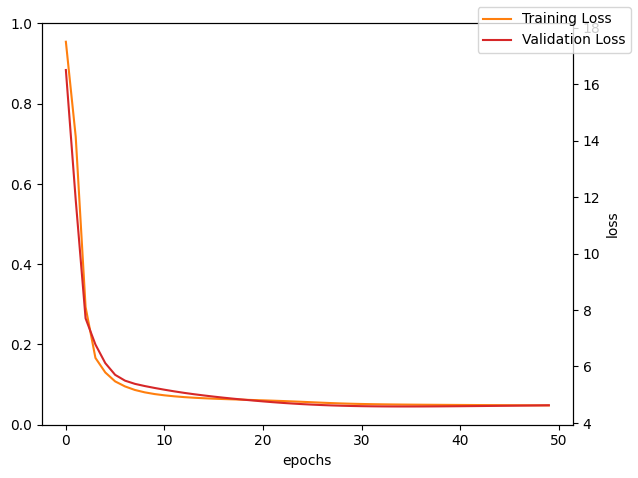

In [73]:
OUTPUT_SIZE = 2 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 50 #  BEST: 50
DROPOUT = 0.2 #  BEST: 0.0
N_LAYERS = 1 # Number of RNN layers  BEST: 2
HIDDEN_DIM = 64 # Dimension of the lstm's hidden state (Embedding)  BEST: 64
LEARNING_RATE = 1e-2 #  BEST: 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_losses, val_losses = [], []

plotter = PlotTraining()
# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = False).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = False).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

## Evaluation

In [74]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0)

In [75]:
y_pred = model(test_x_pad.to(device)).reshape(900, 2).cpu().detach().numpy()
y_test = test_y_pad.reshape(900, 2).cpu()
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))

Mean absolute error = 1.25
Mean squared error = 3.44
Median absolute error = 0.75
Explain variance score = 0.77
R2 score = 0.77


# Task **2**

## Data Handling and Preprocessing

In [76]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data_task23")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%202_3/train/trajectory_{i}.npz?raw=true", task='task 2'))
  save_dataset(train_data, "train_data_task23")

In [77]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data_task23")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%202_3/test/trajectory_{i}.npz?raw=true", task='task 2'))
  save_dataset(test_data, "test_data_task23")

In [78]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_batch)

## Model Training

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time:  4.23s | train loss    6.407 validation loss    8.887 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time:  4.07s | train loss    6.361 validation loss    8.823 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time:  4.02s | train loss    6.159 validation loss    8.560 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time:  4.03s | train loss    5.293 validation loss    7.514 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time:  4.03s | train loss    3.370 validation loss    5.170 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time:  4.03s | train loss    1.427 validation loss    2.731 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time:  4.09s | train loss    1.078 validation loss    2.259 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time:  4.05s | train loss    1.011 validation loss    2.115 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time:  4.05s | train loss    0.969 validation loss    1.966 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  10 | time:  4.07s | train loss    0.951 validation loss    1.858 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  11 | time:  4.07s | train loss    0.942 validation loss    1.789 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  12 | time:  4.06s | train loss    0.937 validation loss    1.741 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  13 | time:  4.05s | train loss    0.933 validation loss    1.707 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  14 | time:  4.08s | train loss    0.932 validation loss    1.682 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  15 | time:  4.07s | train loss    0.930 validation loss    1.664 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  16 | time:  4.07s | train loss    0.930 validation loss    1.650 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  17 | time:  4.08s | train loss    0.929 validation loss    1.639 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  18 | time:  4.06s | train loss    0.929 validation loss    1.631 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  19 | time:  4.04s | train loss    0.929 validation loss    1.623 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  20 | time:  4.05s | train loss    0.929 validation loss    1.617 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  21 | time:  4.07s | train loss    0.929 validation loss    1.612 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  22 | time:  4.04s | train loss    0.928 validation loss    1.607 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  23 | time:  4.04s | train loss    0.928 validation loss    1.602 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  24 | time:  4.07s | train loss    0.927 validation loss    1.597 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  25 | time:  4.06s | train loss    0.926 validation loss    1.592 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  26 | time:  4.05s | train loss    0.925 validation loss    1.588 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  27 | time:  4.05s | train loss    0.924 validation loss    1.583 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  28 | time:  4.07s | train loss    0.923 validation loss    1.578 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  29 | time:  4.04s | train loss    0.922 validation loss    1.574 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  30 | time:  4.04s | train loss    0.920 validation loss    1.569 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  31 | time:  4.06s | train loss    0.918 validation loss    1.564 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  32 | time:  4.06s | train loss    0.916 validation loss    1.559 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  33 | time:  4.06s | train loss    0.914 validation loss    1.554 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  34 | time:  4.07s | train loss    0.912 validation loss    1.550 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  35 | time:  4.07s | train loss    0.910 validation loss    1.545 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  36 | time:  4.06s | train loss    0.908 validation loss    1.540 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  37 | time:  4.07s | train loss    0.906 validation loss    1.535 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  38 | time:  4.09s | train loss    0.904 validation loss    1.531 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  39 | time:  4.07s | train loss    0.902 validation loss    1.526 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  40 | time:  4.06s | train loss    0.899 validation loss    1.521 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  41 | time:  4.07s | train loss    0.897 validation loss    1.516 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  42 | time:  4.09s | train loss    0.894 validation loss    1.511 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  43 | time:  4.06s | train loss    0.892 validation loss    1.505 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  44 | time:  4.06s | train loss    0.889 validation loss    1.500 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  45 | time:  4.10s | train loss    0.887 validation loss    1.494 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  46 | time:  4.06s | train loss    0.884 validation loss    1.488 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  47 | time:  4.06s | train loss    0.881 validation loss    1.482 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  48 | time:  4.10s | train loss    0.878 validation loss    1.476 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  49 | time:  4.08s | train loss    0.875 validation loss    1.470 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  50 | time:  4.06s | train loss    0.873 validation loss    1.464 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  51 | time:  4.06s | train loss    0.870 validation loss    1.458 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  52 | time:  4.10s | train loss    0.867 validation loss    1.452 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  53 | time:  4.08s | train loss    0.864 validation loss    1.446 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  54 | time:  4.07s | train loss    0.861 validation loss    1.440 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  55 | time:  4.08s | train loss    0.858 validation loss    1.435 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  56 | time:  4.08s | train loss    0.856 validation loss    1.430 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  57 | time:  4.07s | train loss    0.853 validation loss    1.425 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  58 | time:  4.07s | train loss    0.851 validation loss    1.421 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  59 | time:  4.10s | train loss    0.848 validation loss    1.417 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  60 | time:  4.07s | train loss    0.846 validation loss    1.413 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  61 | time:  4.06s | train loss    0.845 validation loss    1.410 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  62 | time:  4.10s | train loss    0.843 validation loss    1.407 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  63 | time:  4.09s | train loss    0.841 validation loss    1.405 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  64 | time:  4.06s | train loss    0.840 validation loss    1.403 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  65 | time:  4.06s | train loss    0.839 validation loss    1.401 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  66 | time:  4.11s | train loss    0.838 validation loss    1.400 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  67 | time:  4.07s | train loss    0.837 validation loss    1.399 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  68 | time:  4.06s | train loss    0.836 validation loss    1.398 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  69 | time:  4.07s | train loss    0.836 validation loss    1.397 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  70 | time:  4.08s | train loss    0.835 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  71 | time:  4.06s | train loss    0.835 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  72 | time:  4.06s | train loss    0.834 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  73 | time:  4.10s | train loss    0.834 validation loss    1.395 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  74 | time:  4.07s | train loss    0.834 validation loss    1.395 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  75 | time:  4.06s | train loss    0.833 validation loss    1.395 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  76 | time:  4.08s | train loss    0.833 validation loss    1.395 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  77 | time:  4.50s | train loss    0.833 validation loss    1.395 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  78 | time:  4.07s | train loss    0.833 validation loss    1.395 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  79 | time:  4.07s | train loss    0.832 validation loss    1.395 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  80 | time:  4.10s | train loss    0.832 validation loss    1.395 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  81 | time:  4.07s | train loss    0.832 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  82 | time:  4.07s | train loss    0.832 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  83 | time:  4.08s | train loss    0.832 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  84 | time:  4.10s | train loss    0.832 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  85 | time:  4.06s | train loss    0.832 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  86 | time:  4.06s | train loss    0.831 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  87 | time:  4.09s | train loss    0.831 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  88 | time:  4.07s | train loss    0.831 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  89 | time:  4.07s | train loss    0.831 validation loss    1.396 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  90 | time:  4.07s | train loss    0.831 validation loss    1.397 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  91 | time:  4.08s | train loss    0.831 validation loss    1.397 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  92 | time:  4.06s | train loss    0.831 validation loss    1.397 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  93 | time:  4.08s | train loss    0.831 validation loss    1.397 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  94 | time:  4.10s | train loss    0.831 validation loss    1.397 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  95 | time:  4.08s | train loss    0.831 validation loss    1.397 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  96 | time:  4.07s | train loss    0.830 validation loss    1.397 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  97 | time:  4.07s | train loss    0.830 validation loss    1.397 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  98 | time:  4.10s | train loss    0.830 validation loss    1.397 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  99 | time:  4.13s | train loss    0.830 validation loss    1.398 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch 100 | time:  4.10s | train loss    0.830 validation loss    1.398 
-----------------------------------------------------------


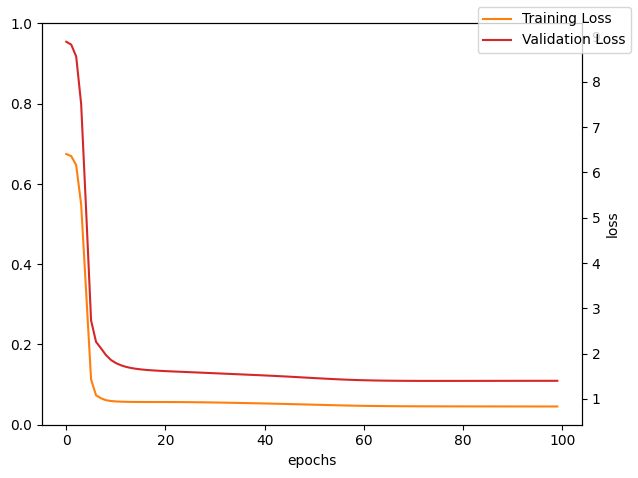

In [79]:
OUTPUT_SIZE = 49*4 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 100 #  BEST: 50, starts overfitting afterwards
DROPOUT = 0.5 #  BEST: 0.5
N_LAYERS = 1 # Number of RNN layers  BEST: 1
HIDDEN_DIM = 512 # Dimension of the lstm's hidden state (Embedding)  BEST: 256
LEARNING_RATE = 0.05 #  BEST: 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_loss, val_loss = [], []

plotter = PlotTraining()

# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = True).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = True).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

## Evaluation

In [82]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0).narrow(dim=-1, start=0, length=2)

In [83]:
y_pred = model(test_x_pad.to(device))
reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2).reshape(900, 98).cpu().detach().numpy()
y_test = test_y_pad.view(test_y_pad.shape[0], test_y_pad.shape[1], 49, 2).reshape(900, 98)
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, reshaped_y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, reshaped_y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, reshaped_y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, reshaped_y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, reshaped_y_pred), 2))

Mean absolute error = 0.78
Mean squared error = 1.75
Median absolute error = 0.45
Explain variance score = 0.89
R2 score = 0.89


# Task **3**

## Data Handling and Preprocessing

In [ ]:
#todo

## Model Implementation

In [ ]:
#todo

## Model Training

In [ ]:
#todo

## Evaluation

In [ ]:
#todo